# **Transforms meet information theory**

# Introduction

### Transforms

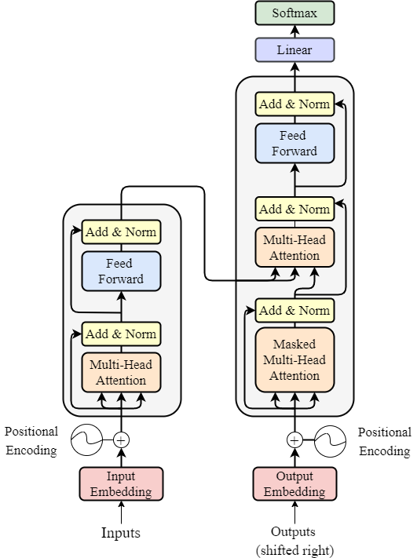

---

### The Loss in transforms related to perplexity

In [ ]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/NURcDHhYe98?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

/usr/local/lib/python3.8/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


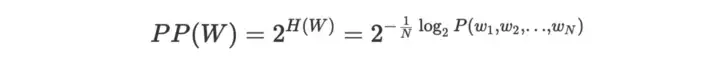

*  The perplexity measures the amount of “randomness” in the model.
*  The best model will be the one that assigns the highest probability to the .
*  Lower perplexity = better model.
*  The average number of words that can be encoded

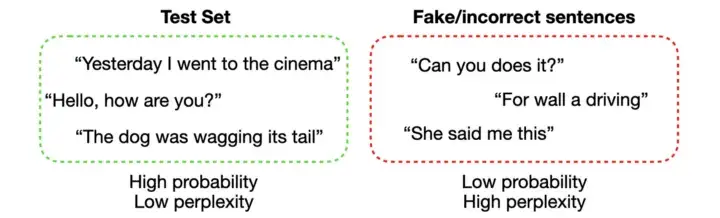

---

# Imports and installation

Installs

In [ ]:
!pip install transformers > /dev/null
!pip install datasets > /dev/null
print("The packages havw been installed")

The packages havw been installed


Imports

In [ ]:
from transformers import pipeline, AutoModel, AutoTokenizer
from transformers import GPT2Config, GPT2Model, GPT2Tokenizer, GPT2LMHeadModel, get_linear_schedule_with_warmup
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding, Trainer, TrainingArguments, AutoConfig

from nltk.tokenize import word_tokenize
from datasets import load_dataset, Dataset
import re
import csv
import nltk
import torch
import random
import numpy as np
import pandas as pd
from nltk import tokenize
from tqdm import tqdm, trange
from torch.optim import AdamW
import torch.nn.functional as F
from scipy.stats import entropy
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Device - GPU

In [ ]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
print(device)

cuda:0


# Pipeline


The pipelines are a great and easy way to use models for inference

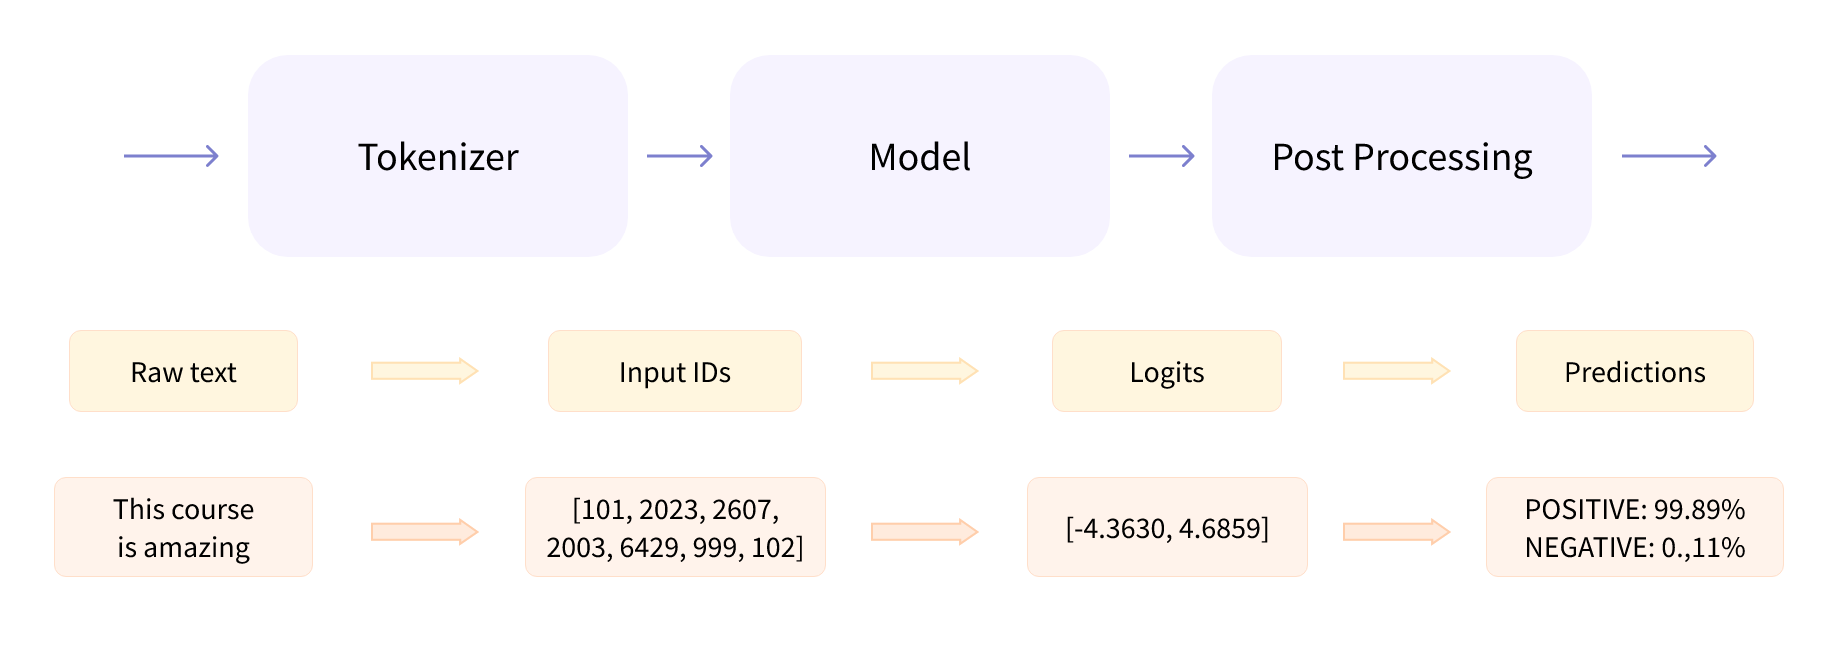

## Pipeline for Text generation

In [ ]:
generator = pipeline("text-generation", model = "gpt2")

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
prompt = "The purpose of this class is to learn different models of language using neural networks"
generator(prompt,  max_length=50, num_return_sequences=3)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'The purpose of this class is to learn different models of language using neural networks and learn to use them as a teaching tool for people who want to learn a wide range of different languages. Through the class we will learn how to use the neural network to'},
 {'generated_text': 'The purpose of this class is to learn different models of language using neural networks as well as how humans can make learning more natural, based on the best data available."\n\nMore information on how the research was done is available at: https://brain'},
 {'generated_text': "The purpose of this class is to learn different models of language using neural networks. Learning them makes you understand something you didn't understand, rather than having to learn the same model every time. This class will also work to learn a number of languages for"}]

## Pipeline for Mask filling

In [ ]:
unmasker = pipeline("fill-mask")

No model was supplied, defaulted to distilroberta-base and revision ec58a5b (https://huggingface.co/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
unmasker("The purpose of this class is to learn different models of language using <mask> networks", top_k=2)

[{'score': 0.9681079387664795,
  'token': 26739,
  'token_str': ' neural',
  'sequence': 'The purpose of this class is to learn different models of language using neural networks'},
 {'score': 0.004823611117899418,
  'token': 46195,
  'token_str': ' semantic',
  'sequence': 'The purpose of this class is to learn different models of language using semantic networks'}]

# **Fine-tune a pretrained model - For Harry Potter books**

## Loading the pretrained tokenizer and model with special tokens

In [ ]:
base_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [ ]:
bos = '<|BOS|>'
eos = '<|EOS|>'
pad = '<|pad|>'

special_tokens_dict = {'eos_token': eos, 'bos_token': bos, 'pad_token': pad}

# the new token is added to the tokenizer
num_added_toks = base_tokenizer.add_special_tokens(special_tokens_dict)

# the model config to which we add the special tokens
config = AutoConfig.from_pretrained('gpt2',
                                    bos_token_id=base_tokenizer.bos_token_id,
                                    eos_token_id=base_tokenizer.eos_token_id,
                                    pad_token_id=base_tokenizer.pad_token_id,
                                    output_hidden_states=False)

# the pre-trained model is loaded with the custom configuration
base_model = GPT2LMHeadModel.from_pretrained('gpt2', config=config)

# the model embedding is resized
base_model.resize_token_embeddings(len(base_tokenizer))

Embedding(50260, 768)

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
harry_potter_books = ""

dir = "/content/gdrive/MyDrive/סמינר NLP/Presentation/"
for i in range(1,8):
  f = open(f'{dir}harry-potter-books-corpora-part-1-7/Book{i}.txt',"r")
  book_text = f.read()
  harry_potter_books = harry_potter_books + book_text[2:-2]

In [ ]:
print(f"Example: {harry_potter_books[3:400]}")

Example: 

THE BOY WHO LIVED 

Mr. and Mrs. Dursley, of number four, Privet Drive, 
were proud to say that they were perfectly normal, 
thank you very much. They were the last people you’d 
expect to be involved in anything strange or 
mysterious, because they just didn’t hold with such 
nonsense. 

Mr. Dursley was the director of a firm called 
Grunnings, which made drills. He was a big, beefy 
man wit


In [ ]:
def processing_text(text, special_tokens_dict):

  pad = special_tokens_dict['pad_token']
  eos = special_tokens_dict['eos_token']
  bos = special_tokens_dict['bos_token']

  # Clean text
  clean_text = text
  clean_text = re.sub(r"'", "", clean_text)
  clean_text = re.sub(r"Page \| \d+ Harry Potter and the Philosophers Stone - J.K. Rowling","",clean_text) # delete title
  clean_text = re.sub(r"Page | \d+ Harry Potter and the Philosophers Stone -J.K. Rowling","",clean_text)   # delete title
  # split to paragraph  with more then 10 words
  clean_text = clean_text.split('\n\n')
  clean_text = [re.sub(r"\n", "", par) for par in clean_text]
  clean_text =  [s for s in clean_text if len(s.split()) >10]
  clean_text = pd.DataFrame(clean_text, columns=["paragraph"])
  clean_text = clean_text[clean_text["paragraph"]!=""]
  clean_text = clean_text[clean_text["paragraph"]!=" "]

  # Add tokens
  clean_text['paragraph'] = bos + ' ' + clean_text['paragraph'] + ' ' + eos

  # Split to train and val
  df_train, df_val = train_test_split(clean_text, train_size = 0.9, random_state = 77)
  print(f'There are {len(df_train)} paragraph for training and {len(df_val)} for validation')

  return df_train, df_val

In [ ]:
df_train, df_val = processing_text(harry_potter_books, special_tokens_dict)
df_train.iloc[4:8]

There are 30827 paragraph for training and 3426 for validation


,paragraph
19390,<|BOS|> After a hurried breakfast they pulled ...
19505,<|BOS|> “Did you see everything I saw?” Harry ...
2667,<|BOS|> Harry wiped his forehead on his sleeve...
10769,<|BOS|> One of the Beauxbatons girls still clu...


Convert tables to Dataset

In [ ]:
train_dataset = Dataset.from_pandas(df_train[['paragraph']])
val_dataset = Dataset.from_pandas(df_val[['paragraph']])

In [ ]:
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['paragraph', '__index_level_0__'],
    num_rows: 30827
})
Dataset({
    features: ['paragraph', '__index_level_0__'],
    num_rows: 3426
})


Finally, tokenize the datasets so that we can use them as training data.

In [ ]:
def tokenize_function(examples):
  return base_tokenizer(examples['paragraph'], padding=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=5,remove_columns=['paragraph'])
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True, num_proc=5, remove_columns=['paragraph'])

print(train_dataset)
print(val_dataset)


#0:   0%|          | 0/7 [00:00<?, ?ba/s]

#1:   0%|          | 0/7 [00:00<?, ?ba/s]

#3:   0%|          | 0/7 [00:00<?, ?ba/s]

#4:   0%|          | 0/7 [00:00<?, ?ba/s]

#2:   0%|          | 0/7 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#4:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['paragraph', '__index_level_0__'],
    num_rows: 30827
})
Dataset({
    features: ['paragraph', '__index_level_0__'],
    num_rows: 3426
})


In [ ]:
base_tokenizer.decode(tokenized_train_dataset['input_ids'][5])

'<|BOS|> “Did you see everything I saw?” Harry asked, unsure whether he wanted to hear the answer. <|EOS|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad

## Training

In [ ]:
model_Harry_Potter_path = dir + 'model_Harry_Potter/'

# HuggingFace Transformers has an API that abstracts the user from the most complex details of the process
training_args = TrainingArguments(
    output_dir=model_Harry_Potter_path,          # output directory
    num_train_epochs=2,                          # total # of training epochs
    per_device_train_batch_size=5,               # batch size per device during training
    per_device_eval_batch_size=32,               # batch size for evaluation
    warmup_steps=200,                            # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                           # strength of weight decay
    prediction_loss_only=True,
    save_steps=1000
)

# In the case of GPT-2, it is also recommended to instantiate the DataCollatorForLanguageModeling class,
# which is responsible for generating the subsets for training (batches).
data_collator = DataCollatorForLanguageModeling(
        tokenizer=base_tokenizer,
        mlm=False
    )

trainer = Trainer(
    model=base_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                       # training arguments, defined above
    data_collator=data_collator,
    train_dataset=tokenized_train_dataset,    # training dataset
    eval_dataset=tokenized_val_dataset        # evaluation dataset
)



In [ ]:
# trainer.train(resume_from_checkpoint=False)
# trainer.save_model()
# base_tokenizer.save_pretrained(model_Harry_Potter_path)

## Load models

In [ ]:
# Pretrained gpt2 model
pretrained_model = GPT2LMHeadModel.from_pretrained("gpt2")
pretrained_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", padding_side='left')

# Model after fine-tune gpt2 model with harry Potter books
fine_tune_potter_model = GPT2LMHeadModel.from_pretrained(model_Harry_Potter_path)
fine_tune_potter_tokenizer = GPT2Tokenizer.from_pretrained(model_Harry_Potter_path, padding_side='left')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/f27b190eeac4c2302d24068eabf5e9d6044389ae/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.25.1",
  "use_cach

## Generate sample

In [ ]:
def generate_sample(model, tokenizer, input_text, device, max_new_tokens = 1):

    input_text = ' '.join([tokenizer.decode(model.config.bos_token_id, skip_special_tokens=True), input_text])

    text_ids = tokenizer.encode(input_text, return_tensors = 'pt')
    text_ids = text_ids.to(device)
    model = model.to(device)

    # set � as bad word that the model shouldn't � generate
    bad_words_ids = []
    for i in range(len(tokenizer)):
      if tokenizer.decode(i) == '�':
        bad_words_ids.append([i])

    # generate
    generated = model.generate(text_ids,
        return_dict_in_generate=True,
        output_scores = True,
        max_new_tokens = max_new_tokens,
        pad_token_id = model.config.eos_token_id,
        bos_token_id = model.config.bos_token_id,
        bad_words_ids = bad_words_ids,
        repetition_penalty = 1.5,
    )

    gen_text, probs = [], []
    gen_ids = generated.sequences[0][len(text_ids[0]):]

    # get the generated word and the probabilitiy of each step
    for id, score in zip(gen_ids, generated.scores):
        text = tokenizer.decode(id, skip_special_tokens=True)
        gen_text.append(text)
        probs.append(torch.softmax(score, dim=-1))
    probs = [p.cpu().numpy()[0] for p in probs]

    return generated.sequences[0][len(text_ids[0]):], gen_text, probs,  generated.scores

In [ ]:
prompt = "Hi Harry,"
potter_ids, potter_gen_tex, potter_tokens_probs, logits = generate_sample(fine_tune_potter_model, fine_tune_potter_tokenizer, prompt, device, max_new_tokens = 100)
ids, gen_tex, tokens_probs, logits = generate_sample(pretrained_model, pretrained_tokenizer, prompt, device, max_new_tokens = 50)

print("\nHarry Potter Model:")
print(prompt + ''.join(potter_gen_tex))
print("\nRegular Model:")
print(prompt + ''.join(gen_tex))


Harry Potter Model:
Hi Harry, I think we should go and see Professor McGonagall. She is very nice to me — she is always looking for new things that might interest us in the future!<|EOS|>

Regular Model:
Hi Harry,
I'm a student at the University of California-Berkeley. I've been studying computer science for about two years now and have recently started working on my PhD thesis in Computer Science (Computer Vision). My main goal is to understand how computers work


# **Information-Theoretic Analysis of Neural Language Models**

## Perplexity
Perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.

In [ ]:
def perplexity(probs):

    # Log Perplexity (= Cross-Entropy = Loss)
    LPP = -np.mean(np.log2(probs))

    return np.log2(LPP)

## Main Function

In [ ]:
def summary(df):
  over_all =  df[['P(word)','Rank', 'Entropy', 'LogPerplexity', 'loss']].mean()
  return pd.DataFrame([over_all], index = ['over_all']).T

In [ ]:
def text_eval(model, tokenizer, input_text, device, shift = 10):

  model.to(device)

  # inputs
  input_tokens = tokenizer.encode(input_text, return_tensors = 'pt')[0]
  all_words = [tokenizer.decode(id) for id in input_tokens]

  # initialization
  all_logits = []
  all_losses = []

  for i in tqdm(range(1,len(input_tokens)+1)):
    with torch.no_grad():
      model_output = model(input_ids = input_tokens[:i].to(device), labels = input_tokens[:i].to(device))
      all_losses.append(model_output.loss.item())
      all_logits.append(model_output.logits[-1])

  # Calculate the distribution for each word - from the logits
  all_dist = torch.softmax(torch.stack(all_logits), dim=-1).cpu().detach().numpy()

  # from shift word for avoind noises
  all_dist = all_dist[shift:]
  all_words = all_words[shift:]
  input_tokens = input_tokens[shift:]
  all_losses = all_losses[shift:]

  # The probability that the word received
  prob_of_words = [dist[id] for dist, id in zip(all_dist, input_tokens)]

  # The ranking of the word among all words
  ranks = [dist.argsort()[::-1][id] for id, dist in zip(input_tokens, all_dist)]

  # Entropy
  entropys = [entropy(dist, base=2) for dist in all_dist]

  # Perplexity
  LogPerplexitys = [perplexity(prob_of_words[:i+1]) for i in range(len(prob_of_words))]

  df = pd.DataFrame([all_words, prob_of_words, ranks, entropys, LogPerplexitys, all_losses],
          index  = ['Word','P(word)','Rank', 'Entropy', 'LogPerplexity', 'loss'])

  return df.T


In [ ]:
# Pretrained gpt2 model
regular_model = GPT2LMHeadModel.from_pretrained("gpt2")
regular_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", padding_side='left')

# Model after fine-tune gpt2 model with harry Potter books
potter_model = GPT2LMHeadModel.from_pretrained(model_Harry_Potter_path)
potter_tokenizer = GPT2Tokenizer.from_pretrained(model_Harry_Potter_path, padding_side='left')

## Regular model and text

In [ ]:
text = 'Machine learning is a field of inquiry devoted to understanding and building methods that learn, that is, methods that leverage data to improve performance on some set of tasks. It is seen as a part of artificial intelligence. Machine learning algorithms build a model based on sample data, known as training data, in order to make predictions or decisions without being explicitly programmed to do so. Machine learning algorithms are used in a wide variety of applications, such as in medicine, email filtering, speech recognition, agriculture, and computer vision, where it is difficult or unfeasible to develop conventional algorithms to perform the needed tasks. A subset of machine learning is closely related to computational statistics, which focuses on making predictions using computers, but not all machine learning is statistical learning. The study of mathematical optimization delivers methods, theory and application domains to the field of machine learning. Data mining is a related field of study, focusing on exploratory data analysis through unsupervised learning. Some implementations of machine learning use data and neural networks in a way that mimics the working of a biological brain. In its application across business problems, machine learning is also referred to as predictive analytics. Learning algorithms work on the basis that strategies, algorithms, and inferences that worked well in the past are likely to continue working well in the future. These inferences can be obvious, such as "since the sun rose every morning for the last 10,000 days, it will probably rise tomorrow morning as well".' #They can be nuanced, such as "X% of families have geographically separate species with color variants, so there is a Y% chance that undiscovered black swans exist Machine learning programs can perform tasks without being explicitly programmed to do so. It involves computers learning from data provided so that they carry out certain tasks. For simple tasks assigned to computers, it is possible to program algorithms telling the machine how to execute all steps required to solve the problem at hand. on the computers part, no learning is needed. For more advanced tasks, it can be challenging for a human to manually create the needed algorithms. In practice, it can turn out to be more effective to help the machine develop its own algorithm, rather than having human programmers specify every needed step The discipline of machine learning employs various approaches to teach computers to accomplish tasks where no fully satisfactory algorithm is available. In cases where vast numbers of potential answers exist, one approach is to label some of the correct answers as valid. This can then be used as training data for the computer to improve the algorithm(s) it uses to determine correct answers. For example, to train a system for the task of digital character recognition, the MNIST dataset of handwritten digits has often been used'

In [ ]:
df = text_eval(regular_model, regular_tokenizer, text, device)
df[190:200]

100%|██████████| 292/292 [00:04<00:00, 59.08it/s]


,Word,P(word),Rank,Entropy,LogPerplexity,loss
190,a,0.000212,18512,7.230427,3.855346,3.052776
191,way,0.000005,19898,2.058239,3.856915,3.045193
192,that,0.000186,10143,7.11235,3.855834,3.031874
193,mim,0.0,5883,0.028143,3.86279,3.042675
194,ics,0.0,938,5.996078,3.869303,3.02777
195,the,0.000203,11887,7.913303,3.868118,3.019197
196,working,0.000605,6356,5.957888,3.866155,3.042607
197,of,0.000063,2035,7.074675,3.865837,3.036315
198,a,0.000099,5931,5.202387,3.865203,3.034473
199,biological,0.001498,26516,5.680972,3.862631,3.048927


**Summary**       



In [ ]:
Model_regular_Text_regular = summary(df)
Model_regular_Text_regular

,over_all
P(word),0.000226
Rank,13977.769504
Entropy,4.585280
LogPerplexity,3.817396
loss,3.134561


**TOP 10 word by entropy - The key word. \
High entropy  - hard to predict**

In [ ]:
df.sort_values(by=['Entropy'], ascending=False)[['Word', 'Entropy',	'P(word)']].head(10)

,Word,Entropy,P(word)
139,The,9.148591,0.000026
258,"""",8.881754,0.000017
260,the,8.824298,0.000213
76,as,8.772641,0.003304
184,use,8.763224,0.000131
6,that,8.528298,0.00065
186,and,8.324701,0.000252
227,",",8.258399,0.000084
82,",",8.232682,0.000276
26,a,8.224957,0.000113


**Rank on histogram**

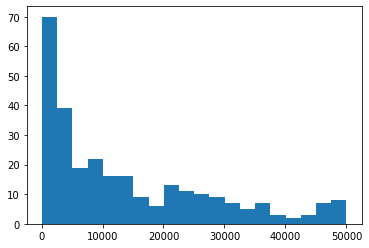

In [ ]:
hist = plt.hist(df['Rank'], bins =20)

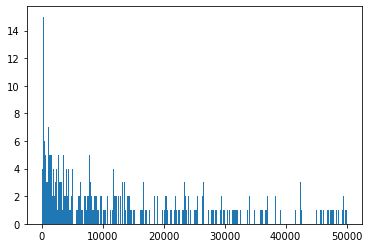

In [ ]:
count, bins,_ = plt.hist(df['Rank'], bins = len(df['Rank']))
hist_entropy = entropy(np.array(count/bins[1:], dtype = float))

In [ ]:
print(f'Shannon Entropy: {hist_entropy}')
print(f'Entropy: {Model_regular_Text_regular.T["Entropy"].values[0]}')
print(f'LogPerplexity: {Model_regular_Text_regular.T["LogPerplexity"].values[0]}')

Shannon Entropy: 2.9610547059025825
Entropy: 4.58528029185834
LogPerplexity: 3.817396231576906


**P(word) as function of possitin in the sentence**

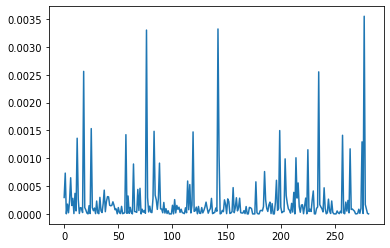

In [ ]:
plt.plot(np.arange(0,len(df['P(word)'])),df['P(word)'])

## Potter with regular text

In [ ]:
df_potter = text_eval(potter_model, potter_tokenizer, text, device)
df_potter.head(10)

100%|██████████| 292/292 [00:04<00:00, 60.83it/s]


,Word,P(word),Rank,Entropy,LogPerplexity,loss
0,and,0.000199,37298,7.846967,3.619941,5.314638
1,building,0.000082,29879,5.530205,3.692728,5.305115
2,methods,0.000002,11530,2.376189,3.898399,5.412271
3,that,0.000042,36162,5.463764,3.889421,5.151438
4,learn,0.000005,7433,4.152188,3.940603,5.427635
5,",",0.000033,981,6.635933,3.933226,5.190829
6,that,0.000676,15268,5.67612,3.867745,5.214749
7,is,0.000055,3584,1.433049,3.862046,4.955242
8,",",0.000063,416,7.123367,3.855624,4.691896
9,methods,0.000019,5747,1.799663,3.86791,4.653532


In [ ]:
Model_Potter_Text_regular = summary(df_potter)
Model_Potter_Text_regular

,over_all
P(word),0.000117
Rank,12642.734043
Entropy,3.973552
LogPerplexity,3.958819
loss,4.088608


In [ ]:
df_potter.sort_values(by=['Entropy'], ascending=False)[['Word', 'Entropy',	'P(word)']].head(10)

,Word,Entropy,P(word)
184,use,9.652014,0.00012
215,as,9.304316,0.000158
258,"""",9.192673,0.000111
76,as,9.161133,0.001275
139,The,8.721292,0.000035
77,in,8.500265,0.00011
186,and,8.485761,0.000083
127,using,8.315217,0.000081
55,without,8.061725,0.000007
42,",",7.915869,0.000027


## Potter with his Wikipedia entry

In [ ]:
text_potter = "The series follows the life of a boy named Harry Potter. In the first book, Harry Potter and the Philosopher's Stone, Harry lives in a cupboard under the stairs in the house of the Dursleys, his aunt, uncle and cousin. The Dursleys consider themselves perfectly normal, but at the age of eleven, Harry discovers that he is a wizard. He meets a half-giant named Hagrid who invites him to attend the Hogwarts School of Witchcraft and Wizardry. Harry learns that as a baby, his parents were murdered by the dark wizard Lord Voldemort. When Voldemort attempted to kill Harry, his curse rebounded and Harry survived with a lightning-shaped scar on his forehead"
df_potter_text_potter = text_eval(potter_model, potter_tokenizer, text_potter, device)
df_potter_text_potter.head(7)

100%|██████████| 141/141 [00:01<00:00, 70.85it/s]


,Word,P(word),Rank,Entropy,LogPerplexity,loss
0,Potter,0.000127,22224,2.953771,3.694036,4.305872
1,.,0.000019,3574,6.122712,3.839655,4.064306
2,In,0.000058,8308,5.474794,3.831235,4.047331
3,the,0.00006,1499,7.548134,3.825656,3.824804
4,first,0.000062,2095,5.625626,3.821777,3.685626
5,book,0.000032,21025,2.521965,3.834793,3.565491
6,",",0.000064,8129,5.536822,3.829985,3.372183


In [ ]:
Model_Potter_Text_Wiki = summary(df_potter_text_potter)
Model_Potter_Text_Wiki

,over_all
P(word),0.000177
Rank,15351.007634
Entropy,4.073184
LogPerplexity,4.043834
loss,2.968663


In [ ]:
df_potter_text_potter.sort_values(by=['Entropy'], ascending=False)[['Word', 'Entropy',	'P(word)']].head(10)

,Word,Entropy,P(word)
123,a,9.444356,0.000077
99,were,8.449086,0.00013
62,a,8.208941,0.000096
29,the,8.155979,0.000042
72,named,8.040108,0.000095
23,the,7.63489,0.000131
34,his,7.617656,0.000061
3,the,7.548134,0.00006
61,is,7.371453,0.000055
19,a,7.138385,0.000219


## Potter with text from book

In [ ]:
text_potter_known = "Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense"
df_potter_book = text_eval(potter_model, potter_tokenizer, text_potter_known, device)
df_potter_book.head(10)

100%|██████████| 60/60 [00:00<00:00, 86.75it/s]


,Word,P(word),Rank,Entropy,LogPerplexity,loss
0,",",0.000041,3114,8.753384,3.863716,4.144968
1,Pri,0.0,5181,0.035807,4.516892,4.173535
2,vet,0.0,16137,0.000716,4.827257,3.82602
3,Drive,0.000007,19938,1.636104,4.676988,3.531713
4,",",0.000017,531,7.992742,4.563103,3.337033
5,were,0.000069,46759,7.621543,4.459586,3.270767
6,proud,0.000009,9605,2.494428,4.408956,3.678192
7,to,0.000035,19818,5.833599,4.353062,3.504824
8,say,0.000001,5326,2.653296,4.344993,3.52149
9,that,0.00059,3763,4.419782,4.275221,3.362035


In [ ]:
Model_Potter_Text_book = summary(df_potter_book)
Model_Potter_Text_book

,over_all
P(word),0.000290
Rank,12880.360000
Entropy,4.110056
LogPerplexity,4.151217
loss,3.066223


In [ ]:
df_potter_book.sort_values(by=['Entropy'], ascending=False)[['Word', 'Entropy',	'P(word)']].head(10)

,Word,Entropy,P(word)
0,",",8.753384,0.000041
31,be,8.674841,0.00023
4,",",7.992742,0.000017
21,were,7.799225,0.000056
11,were,7.749868,0.000022
5,were,7.621543,0.000069
14,",",7.198795,0.000018
48,such,6.955457,0.000252
34,anything,6.82641,0.0004
36,or,6.725089,0.000076


# Summary

In [ ]:
all_table_entropy = [Model_regular_Text_regular, Model_Potter_Text_regular, Model_Potter_Text_Wiki, Model_Potter_Text_book]
summary_results = Model_regular_Text_regular[['over_all']]
summary_results.columns = ['regular_model']
summary_results['Potter_text_regular'] = Model_Potter_Text_regular['over_all']
summary_results['Potter_text_Wiki'] = Model_Potter_Text_Wiki['over_all']
summary_results['Potter_text_book'] = Model_Potter_Text_book['over_all']

In [ ]:
summary_results.style.highlight_max(color = 'lightgreen', axis = 1)

,regular_model,Potter_text_regular,Potter_text_Wiki,Potter_text_book
P(word),0.000226,0.000117,0.000177,0.000290
Rank,13977.769504,12642.734043,15351.007634,12880.360000
Entropy,4.585280,3.973552,4.073184,4.110056
LogPerplexity,3.817396,3.958819,4.043834,4.151217
loss,3.134561,4.088608,2.968663,3.066223


In [ ]:
summary_results.style.highlight_min(color = 'lightblue', axis = 1)

,regular_model,Potter_text_regular,Potter_text_Wiki,Potter_text_book
P(word),0.000226,0.000117,0.000177,0.000290
Rank,13977.769504,12642.734043,15351.007634,12880.360000
Entropy,4.585280,3.973552,4.073184,4.110056
LogPerplexity,3.817396,3.958819,4.043834,4.151217
loss,3.134561,4.088608,2.968663,3.066223


# BONUS

## News headlines dataset

In [ ]:
head_news = pd.read_json('/content/gdrive/MyDrive/סמינר NLP/Presentation/News_Category_Dataset_v3.json', lines=True)
head_news = head_news[head_news['date']>'2020-01-01'][['headline']] # headlines after 2020-01-01
head_news = head_news[head_news.headline.apply(lambda x: len(x.split())>15)] # headlines with more then 15 word
head_news = head_news.sample(n=30)
head_news.head(2)

,headline
4333,How To Know If Your Own Doctor (Or A Doctor Yo...
24,‘Beautiful And Sad At The Same Time’: Ukrainia...


In [ ]:
mean_all = 0
key_words = []
for i, news in zip(range(len(head_news['headline'])), head_news['headline']):
  df_news = text_eval(regular_model, regular_tokenizer, news, device, shift=0)
  mean_all += df_news['Entropy'].mean()

In [ ]:
mean_all/len(head_news['headline'])

6.791390181627177

# BIO

[Evaluation metrics for language models](https://thegradient.pub/understanding-evaluation-metrics-for-language-models/)

[Perplexity in language models](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94)

[Text generation with GPT-2](https://www.modeldifferently.com/en/2021/12/generaci%C3%B3n-de-fake-news-con-gpt-2/)

[Entropy, Perplexity and Its Applications](https://leimao.github.io/blog/Entropy-Perplexity/)

[Hugging Face - perplexity](https://huggingface.co/spaces/evaluate-metric/perplexity)